In [1]:
import os

wd = '/home/michael/gitrepos/proteinGeometryData'
wd_pdb = os.path.join(wd, 'pdb')
wd_backbone = os.path.join(wd, 'backbone')
wd_segment = os.path.join(wd, 'segment')
wd_binary = os.path.join(wd, 'binary')
wd_sol = os.path.join(wd, 'original_sol')
wd_nmr = os.path.join(wd, 'nmr')

os.chdir(wd)

# !pip install biopandas
# !pip freeze > requirements.txt

from IPython.display import clear_output
clear_output(wait=True)

import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

# Setting up the plot style
sns.set(style="whitegrid")

In [4]:
import requests

# URL of the file to download
fn = 'pdb_entry_type.txt'
url = "https://files.wwpdb.org/pub/pdb/derived_data/" + fn
response = requests.get(url)
if response.status_code == 200:
    with open(os.path.join(wd,fn), 'wb') as fd:
        fd.write(response.content)
else:
    raise Exception(f'Failed to download {url}: {response.status_code}')

!head -n 5 pdb_entry_type.txt

100d	nuc	diffraction
101d	nuc	diffraction
101m	prot	diffraction
102d	nuc	diffraction
102l	prot	diffraction


In [6]:
# convert from txt to pandas
import pandas as pd

# Read the file into a pandas DataFrame
# Assuming the file is tab-delimited and has no header row
df = pd.read_csv(os.path.join(wd,fn), delimiter='\t', header=None)

# Optionally, name the columns
df.columns = ['Protein_ID', 'Type', 'Method']

# Filter Type='prot' and Method='NMR'
df = df[(df['Type'] == 'prot') & (df['Method'] == 'NMR')].copy()

df['Count'] = 1
df_total = df[['Type','Method','Count']].groupby(['Type','Method']).sum().reset_index()
df_total = df_total[['Method','Count']].copy()
df_total

# Export the df_total DataFrame to LaTeX
with open(os.path.join(wd,'df_total.tex'), 'w') as tf:
    tf.write(df_total.to_latex(index=False))

# Export the df DataFrame to LaTeX
df.to_csv(os.path.join(wd,'pdb_entry_prot_NMR.csv'), index=False)

In [2]:
import os
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Read the selected_protein_ids.csv file
selected_protein_ids = pd.read_csv(os.path.join(wd, 'pdb_entry_prot_NMR.csv'))
selected_protein_ids = selected_protein_ids['Protein_ID'].tolist()

# Get the number of available CPU cores
num_cores = os.cpu_count()

# Set the number of threads to be one less than the number of cores
num_threads = num_cores - 1

# Create a directory to store the downloaded PDB files
os.makedirs(wd_pdb, exist_ok=True)

# Function to download a PDB file
def download_pdb(protein_id):
    file_path = os.path.join(wd_pdb, f'{protein_id}.pdb')

    # Check if the file already exists
    if os.path.exists(file_path):
        return

    url = f'http://files.rcsb.org/download/{protein_id}.pdb'
    response = requests.get(url)

    if response.status_code == 200:
        with open(file_path, 'wb') as f:
            f.write(response.content)

# Download PDB files for the selected Protein_IDs in parallel with progress bar
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    list(tqdm(executor.map(download_pdb, selected_protein_ids), total=len(selected_protein_ids)))

 34%|███▍      | 4295/12496 [06:57<14:20,  9.53it/s]  

In [3]:
# Extracting the chains from the PDB files
from concurrent.futures import ThreadPoolExecutor
import os
import biopandas.pdb as bp
from tqdm import tqdm

def detect_invalid_residue(df_row):
    residue_name = df_row.iloc[1]

    if residue_name in ['PRO', 'GLY']:
        return False

    atoms = df_row.iloc[2].split(' ')
    if "N" not in atoms:
        return False
    
    if "CA" not in atoms:
        return False
    
    if "C" not in atoms:
        return False
    
    if "H" not in atoms and "H1" not in atoms:
        return False
    
    if "HA" not in atoms:
        return False
    
    return True

def process_pdb_file(fn):
    # Define the PDB file path
    pdb_id = fn.split('.')[0]
    pdb_fn = os.path.join(wd, 'pdb', fn)

    # Load PDB file
    ppdb = bp.PandasPdb().read_pdb(pdb_fn)

    # Get model indices
    df_MODEL = ppdb.get_model_start_end().copy()

    ATOM = ['C','CA','N','H','H1','HA','HA1']
    COLUMNS = [
        'atom_number',
        'atom_name',
        'residue_name',
        'chain_id',
        'residue_number',
        'x_coord',
        'y_coord',
        'z_coord',
        'b_factor',
        'segment_id',
        'element_symbol',
        'model_id'
    ]
    for _, row in df_MODEL.iterrows():
        model_idx = int(row.model_idx)
        model = ppdb.get_model(model_index=model_idx).df['ATOM']
        # Get only the ATOM records
        model = model[model['atom_name'].isin(ATOM)]
        chains = sorted(list(set(model['chain_id'])))
        if len(chains) > 0:
            chain = chains[0] # only one chain 
            df = model[model['chain_id'] == chain]                                                                                                                                                                                                                                                              .copy()

            # removing invalid residues
            col_residue_atoms = df.groupby(['residue_number']).agg({'residue_name': 'min', 'atom_name': lambda x : ' '.join(x)}).reset_index()
            col_residue_atoms['is_valid'] = col_residue_atoms.apply(detect_invalid_residue, axis=1)
            
            valid_residues = col_residue_atoms[col_residue_atoms['is_valid']]['residue_number']
            valid_residues = set(valid_residues)

            df = df[df['residue_number'].isin(valid_residues)]
            
            fn = os.path.join(wd_backbone, f'{pdb_id}_model{model_idx}_chain{chain}.csv')
            df.to_csv(fn, index=False)
            break  


# Set up working directories
wd_pdb = os.path.join(wd, 'pdb')
wd_backbone = os.path.join(wd, 'backbone')

# Create output directory
os.makedirs(wd_backbone, exist_ok=True)

# Get list of PDB files
pdb_files = sorted(os.listdir(wd_pdb))

# Number of threads (adjust as needed)
num_threads = os.cpu_count() - 1

# Parallel processing
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    list(tqdm(executor.map(process_pdb_file, pdb_files), total=len(pdb_files)))

clear_output()

In [2]:
# Create segments
import numpy as np
import pandas as pd
from tqdm import tqdm

wd_segment = os.path.join(wd, 'segment')

# Create output directory
os.makedirs(wd_segment, exist_ok=True)

cols = [
    'residue_number',
    'residue_name',
    'atom_number',
    'atom_name',
    'chain_id',
    'x_coord',
    'y_coord',
    'z_coord'
]

for fn in tqdm(os.listdir(wd_backbone)):
    df = pd.read_csv(os.path.join(wd_backbone, fn))
    df = df[cols]

    # Assume df is your original DataFrame
    df_residue = df.groupby(['residue_number']).max().reset_index()

    # Convert the 'residue_number' column to a NumPy array
    residue_number = df_residue['residue_number'].to_numpy()

    # Calculate the difference between consecutive entries in the residue_number array
    diffs = np.diff(residue_number)

    # Identify indices where the difference is larger than 1
    split_indices = np.where(diffs > 1)[0] + 1
    
    # Split the array at these indices
    split_arrays = np.split(residue_number, split_indices)

    # Keeping segments which has at least 3 residues.
    cleaned_split_arrays = []
    for index, array in enumerate(split_arrays):
        if len(array) > 3:
            cleaned_split_arrays.append(split_arrays[index])
    
    fn = fn.replace('.csv','')
    for k, residue_numbers in enumerate(cleaned_split_arrays):
        df_segment = df[df['residue_number'].isin(residue_numbers)]

        # Removing the amina hydrogen from the first residue
        row_firstH = df_segment.loc[(df_segment['residue_number'] == residue_numbers[0]) & ((df_segment['atom_name'] == 'H') | (df_segment['atom_name'] == 'H1'))]
        df_segment = df_segment.drop(row_firstH.index)
        
        fn_segment = os.path.join(wd_segment, f'{fn}_segment{k}.csv')
        df_segment.to_csv(fn_segment, index=False)

100%|██████████| 12362/12362 [19:44<00:00, 10.44it/s] 


In [3]:
# create binary strings
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.spatial import distance

wd_segment = os.path.join(wd, 'segment')

def point_plane_distance(point, plane_points):
    """
    Calculate the signed distance from a point to a plane defined by three points.
    Parameters:
        point (numpy array): The point [x, y, z] we want to check.
        plane_points (numpy array): 3x3 array where each row is a point [x, y, z] defining the plane.
    Returns:
        float: The signed distance from the point to the plane.
    """
    # Calculate the normal vector of the plane
    normal_vector = np.cross(plane_points[1] - plane_points[0], plane_points[2] - plane_points[0])
    
    norm_nv = np.linalg.norm(normal_vector)
    
    if norm_nv == 0:
        raise Exception("Normal vector is null!")

    # Calculate the signed distance
    signed_distance = np.dot(normal_vector, point - plane_points[0]) / norm_nv
    
    return signed_distance


def construct_ddgp_order_1(df):
    """
    Constructs the following ddgp order: N^1, CA^1, HA^1, ..., C^{i-1}, H^i, N^i, CA^i, HA^i, ..., C^n, where n is the number of vertices of the ddgp graph.
    Parameters:
        df (DataFrame): DataFrame containing the 'x' column with 3D coordinates.
    Returns:
        order_1 (numpy array): nx4 array containing:
            (a) in the first column, the DataFrame indices of the elements of the proposed 3-DDGP order_1; 
            (b) in the other three columns, the neigbours which are utilized to emerge the vertices in the R^3;
                order_1[i][1] is closer to order_1[i][0] in the order than order_1[i][2] is, and so on.    
    """

    # df['myind'] = [str(i) for i in range(len(df))]
    df = df.reset_index()
    df['myindex'] = df['index'].apply(lambda x : str(x))
    df_residue_info = df.groupby(['residue_number']).agg({'residue_name': 'min', 'atom_name': lambda x : ' '.join(x), 'myindex': lambda y : ' '.join(y)}).reset_index()
    df = df.drop(['myindex'], axis=1)

    # atom_names_im1 = df_residue_info.iloc[0][2].split(' ')
    atom_names_im1 = df_residue_info.iloc[0].iloc[2].split(' ')
    # atom_indexes_im1 = [int(atom_index) for atom_index in df_residue_info.iloc[0][3].split(' ')]
    atom_indexes_im1 = [int(atom_index) for atom_index in df_residue_info.iloc[0].iloc[3].split(' ')]
    atoms_im1 = {atom_names_im1[k]: atom_indexes_im1[k] for k in range(len(atom_names_im1))}

    # Creating the order_1
    order_1 = np.zeros((len(df), 4))

    # The first three elements of the order
    order_1[0][0] = atoms_im1['N']
    order_1[1][0] = atoms_im1['CA']
    order_1[2][0] = atoms_im1['HA']

    # The first three elements of the order are not calculated using previous neighbours.
    order_1[0][1] = np.nan
    order_1[1][1] = np.nan
    order_1[2][1] = np.nan
    order_1[0][2] = np.nan
    order_1[1][2] = np.nan
    order_1[2][2] = np.nan
    order_1[0][3] = np.nan
    order_1[1][3] = np.nan
    order_1[2][3] = np.nan

    current_i = 3
    for ind, row in df_residue_info.iloc[1:].iterrows():
        #atom_names_i = row[2].split(' ')
        atom_names_i = row.iloc[2].split(' ')
        # atom_indexes_i = [int(atom_index) for atom_index in row[3].split(' ')]
        atom_indexes_i = [int(atom_index) for atom_index in row.iloc[3].split(' ')]
        atoms_i = {atom_names_i[k]: atom_indexes_i[k] for k in range(len(atom_names_i))}

        ################################
        
        if 'C' in atoms_im1:
            order_1[current_i][0] = atoms_im1['C']
        else:
            raise Exception("Atom 'C' does not exist in the %d-th residue!" % ind-1)

        order_1[current_i][1] = atoms_im1['N']
        order_1[current_i][2] = atoms_im1['CA']
        order_1[current_i][3] = atoms_im1['HA']

        ################################

        thisH = ''
        if 'H' in atoms_i:
            thisH = 'H'
        elif 'H1' in atoms_i:
                thisH = 'H1'
                print(thisH)
        else:
            raise Exception("Atom 'H' does not exist in the %d-th residue!" % ind)
        order_1[current_i + 1][0] = atoms_i[thisH]

        order_1[current_i + 1][1] = atoms_im1['CA']
        order_1[current_i + 1][2] = atoms_im1['C']
        order_1[current_i + 1][3] = atoms_im1['HA']

        ################################

        if 'N' in atoms_i:
            order_1[current_i + 2][0] = atoms_i['N']
        else:
            raise Exception("Atom 'N' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 2][1] = atoms_im1['CA']
        order_1[current_i + 2][2] = atoms_im1['C']
        order_1[current_i + 2][3] = atoms_i[thisH]

        ################################

        if 'CA' in atoms_i:
            order_1[current_i + 3][0] = atoms_i['CA']
        else:
            raise Exception("Atom 'CA' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 3][1] = atoms_im1['C']
        order_1[current_i + 3][2] = atoms_i['N']
        order_1[current_i + 3][3] = atoms_i[thisH]

        ################################

        if 'HA' in atoms_i:
            order_1[current_i + 4][0] = atoms_i['HA']
        else:
            raise Exception("Atom 'HA' does not exist in the %d-th residue!" % ind)

        order_1[current_i + 4][1] = atoms_i['N']
        order_1[current_i + 4][2] = atoms_i['CA']
        order_1[current_i + 4][3] = atoms_i[thisH]

        ################################

        atom_names_im1 = atom_names_i.copy()
        atom_indexes_im1 = atom_indexes_i.copy()
        atoms_im1 = atoms_i.copy()
        
        current_i = current_i + 5
    
    # The last element of the order
    if 'C' in atoms_i:
        order_1[current_i][0] = atoms_im1['C']
    else:
        raise Exception("Atom 'C' does not exist in the %d-th residue!" % ind)
    
    # The neighbours of the last element
    order_1[current_i][1] = atoms_i['N']
    order_1[current_i][2] = atoms_i['CA']
    order_1[current_i][3] = atoms_i['HA']

    return order_1


def calculate_b_column(df, order=[]):
    """
    Calculate the binary column 'b' based on the 'x' column of the DataFrame.
    Parameters:
        df (DataFrame): DataFrame containing the 'x' column with 3D coordinates.
        order (numpy array): nx4 array containing:
            (a) in the first column, the DataFrame indices of the elements of the proposed 3-DDGP order_1; 
            (b) in the other three columns, the neigbours which are utilized to emerge the vertices in the R^3;
                order_1[i][1] is closer to order_1[i][0] in the order than order_1[i][2] is, and so on.
    Returns:
        Series: Pandas Series containing the binary values for the 'b' column.
    """

    # When no order is passed, we assume the DataFrame order is a 3-DMDGP order
    if len(order) == 0:
        col0 = list(range(len(df)))
        col1 = list(range(-3, len(df)-3))
        col2 = list(range(-2, len(df)-2))
        col3 = list(range(-1, len(df)-1))
        col1[0:3] = [np.nan, np.nan, np.nan]
        col2[0:3] = [np.nan, np.nan, np.nan]
        col3[0:3] = [np.nan, np.nan, np.nan]
        order = np.array([col0, col1, col2, col3,])
        order = np.transpose(order)

    b_values = []
    for i in range(len(df)):
        if i < 3:
            # Not enough points to define a plane
            b_values.append(None)
            continue
        plane_points = np.array(df.iloc[order[i][1:4].astype(int)]['x'].tolist())
        current_point = df.iloc[order[i][0].astype(int)]['x']
        distance_to_plane = point_plane_distance(current_point, plane_points)
        b_values.append(int(distance_to_plane >= 0))
    return pd.Series(b_values)


def flip_b_column_if_needed(b_col):
    """
    Flip the binary column 'b' if the 4th element (index 3) is 1.
    Parameters:
        b_col (Series): Panda Series containing the 'b' column.
    Returns:
        Series: Pandas Series containing the binary values for the 'b' column flipped around the fourth position.
    """
    if len(b_col) > 3 and b_col.iloc[3] == 1:
        b_col = b_col.apply(lambda x: 1 - x if x is not None else None)
    return b_col


def write_binary(fn_binary, df, order, b_col):
    df_binary = df[['residue_number', 'atom_name']].copy()
    indices = np.zeros([order.shape[0], 1])
    for i in range(order.shape[0]):
        indices[int(order[i][0])] = i
    df_binary['order'] = indices
    df_binary.sort_values(by=['order'], inplace=True)
    df_binary.drop("order", axis='columns', inplace=True)

    # Guarantees that new columns will not be sorted
    df_binary.reset_index(inplace=True)
    df_binary.rename(columns={'index': 'order'}, inplace=True)

    df_binary['N_1'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 1].astype(int)))
    df_binary['N_2'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 2].astype(int)))
    df_binary['N_3'] = np.concatenate((np.array([np.nan, np.nan, np.nan]), order[3:, 3].astype(int)))
    df_binary['b'] = b_col

    df_binary.to_csv(fn_binary, index=False)


os.makedirs(wd_binary, exist_ok=True)

for fn in tqdm(os.listdir(wd_segment)):
    try:
        fn_segment = os.path.join(wd_segment, fn)
        fn_binary = os.path.join(wd_binary, fn.split('.')[0] + '_binary' + '.csv')
        df = pd.read_csv(fn_segment)
        order_1 = construct_ddgp_order_1(df)
        # Create col x
        df['x'] = df.apply(lambda row: np.array([row['x_coord'], row['y_coord'], row['z_coord']]), axis=1)
        # Calculate the 'b' column
        b_col = calculate_b_column(df, order_1)
        b_col = flip_b_column_if_needed(b_col)
        write_binary(fn_binary, df, order_1, b_col)
    except Exception as myexception:
        print('File %s: ' %fn + myexception.args[0])

  0%|          | 40/72983 [00:07<3:47:57,  5.33it/s]

File 6svh_model1_chainA_segment1.csv: Normal vector is null!


  1%|          | 639/72983 [01:34<1:43:02, 11.70it/s]

File 1ah1_model1_chainA_segment0.csv: Normal vector is null!


 10%|▉         | 7096/72983 [10:21<1:06:35, 16.49it/s] 

File 1dvd_model1_chainA_segment6.csv: Normal vector is null!


 10%|▉         | 7162/72983 [10:25<1:01:30, 17.84it/s]

File 6sve_model1_chainA_segment0.csv: Normal vector is null!


 10%|▉         | 7238/72983 [10:32<2:15:34,  8.08it/s]

File 1dvc_model1_chainA_segment5.csv: Normal vector is null!


 14%|█▍        | 10181/72983 [13:52<56:06, 18.65it/s]  

File 1dvc_model1_chainA_segment6.csv: Normal vector is null!


 17%|█▋        | 12255/72983 [16:18<1:06:12, 15.29it/s]

File 1dvd_model1_chainA_segment5.csv: Normal vector is null!


 21%|██        | 15002/72983 [19:26<57:05, 16.93it/s]  

H1


 24%|██▍       | 17506/72983 [22:48<1:12:17, 12.79it/s]

H1


 29%|██▉       | 21222/72983 [28:38<1:15:09, 11.48it/s]

File 6svc_model1_chainA_segment1.csv: Normal vector is null!


 33%|███▎      | 24233/72983 [32:36<39:10, 20.74it/s]  

File 1bwm_model1_chainA_segment9.csv: Normal vector is null!


 34%|███▍      | 24983/72983 [33:28<1:28:34,  9.03it/s]

File 6sve_model1_chainA_segment1.csv: Normal vector is null!


 35%|███▌      | 25545/72983 [34:06<49:16, 16.04it/s]  

File 5i1r_model1_chainA_segment0.csv: Normal vector is null!


 40%|████      | 29532/72983 [39:06<1:06:24, 10.91it/s]

File 7hsc_model1_chainA_segment9.csv: Normal vector is null!


 44%|████▎     | 31902/72983 [41:55<39:27, 17.35it/s]  

File 1j6t_model1_chainA_segment4.csv: Normal vector is null!


 46%|████▌     | 33593/72983 [43:51<40:53, 16.05it/s]  

File 6svc_model1_chainA_segment0.csv: Normal vector is null!


 48%|████▊     | 34816/72983 [45:15<36:48, 17.28it/s]  

File 1kdu_model1_chainA_segment5.csv: Normal vector is null!


 50%|████▉     | 36176/72983 [46:51<31:39, 19.38it/s]  

File 5i1r_model1_chainA_segment3.csv: Normal vector is null!


 54%|█████▎    | 39163/72983 [50:10<51:30, 10.94it/s]  

File 1ckr_model1_chainA_segment9.csv: Normal vector is null!


 57%|█████▋    | 41388/72983 [52:42<31:54, 16.50it/s]  

File 2orc_model1_chainA_segment4.csv: Normal vector is null!


 63%|██████▎   | 45989/72983 [57:56<27:46, 16.20it/s]  

File 6svh_model1_chainA_segment0.csv: Normal vector is null!


 63%|██████▎   | 46096/72983 [58:03<24:47, 18.07it/s]

File 1bwm_model1_chainA_segment11.csv: Normal vector is null!


 65%|██████▌   | 47717/72983 [59:52<30:27, 13.82it/s]  

File 1dvd_model1_chainA_segment7.csv: Normal vector is null!


 71%|███████   | 51915/72983 [1:04:59<22:06, 15.88it/s]  

File 1dvc_model1_chainA_segment7.csv: Normal vector is null!


 77%|███████▋  | 56355/72983 [1:09:51<20:49, 13.31it/s]

File 1j6t_model1_chainA_segment8.csv: Normal vector is null!


 83%|████████▎ | 60336/72983 [1:14:31<11:21, 18.56it/s]  

File 1kdu_model1_chainA_segment4.csv: Normal vector is null!


 93%|█████████▎| 67818/72983 [1:23:11<06:17, 13.69it/s]

File 2mrb_model1_chainA_segment0.csv: Normal vector is null!


100%|█████████▉| 72664/72983 [1:30:15<00:26, 11.95it/s]  

File 1kdu_model1_chainA_segment7.csv: Normal vector is null!


100%|██████████| 72983/72983 [1:30:44<00:00, 13.41it/s]


In [2]:
# wd_binary = os.path.join(wd, 'binary')
M = {'fn':[], 'n':[], 's':[], 'order': [], 'N_1': [], 'N_2': [], 'N_3': []}

for fn in tqdm(os.listdir(wd_binary)):
    fn = os.path.join(wd_binary, fn)
    df = pd.read_csv(fn)
    # convert from b to s
    s = ''.join(df['b'].dropna().astype(int).astype(str))
    s = s[1:] # remove b_4
    order = ''.join(df['order'].astype(int).astype(str))
    N_1 = ' '.join(df['N_1'].dropna().astype(int).astype(str))
    N_2 = ' '.join(df['N_2'].dropna().astype(int).astype(str))
    N_3 = ' '.join(df['N_3'].dropna().astype(int).astype(str))
    M['fn'].append(fn)
    M['s'].append(s)
    M['n'].append(len(s))
    M['order'].append(order)
    M['N_1'].append(N_1)
    M['N_2'].append(N_2)
    M['N_3'].append(N_3)

M = pd.DataFrame(M)
# M.to_csv('df_strings.csv', index=False)

100%|██████████| 72957/72957 [30:07<00:00, 40.35it/s]  


In [ ]:
# create *.sol files
import re

# extract atoms coordinates
def extract_coordinates(df):
    if len(df['x']) > 0:
        df['x'] = df['x'].apply(lambda x: eval(re.sub(" +", ",", re.sub(r"\[\s+","[", x))))
        x = np.array(df['x'].to_list())
        return x
    return None

os.makedirs(wd_sol, exist_ok=True)

# OBS: The files of the 'binery' folder represent the solvable ddgp problems.
# Since the files of the 'segment' folder might not have a correspondent file in the 'binary' folder,
# we iterate over the 'binary' files.
for fn in tqdm(M['fn']):
    fn_segment = os.path.join(wd_segment, fn.split('/')[-1])
    fn_segment = fn_segment.replace('_binary.csv','.csv')
    fn_sol = os.path.join(wd_sol, fn_segment.split('/')[-1])
    fn_sol = fn_sol.replace('.csv','.sol')
    if os.path.exists(fn_sol):
        continue
    # df_binary = pd.read_csv(fn)
    df = pd.read_csv(fn_segment)
    df['x'] = df.apply(lambda row: str(np.array([row['x_coord'], row['y_coord'], row['z_coord']])), axis=1)
    x = extract_coordinates(df)
    np.savetxt(fn_sol, x)


In [3]:
# Counting the number of fixed-size binary subsequences.
import math

def flip_b_column_if_needed(b_col):
    """
    Flip the binary column 'b' if the 4th element (index 3) is 1.
    Parameters:
        b_col (Series): Panda Series containing the 'b' column.
    Returns:
        Series: Pandas Series containing the binary values for the 'b' column flipped around the fourth position.
    """
    if len(b_col) > 3 and b_col.iloc[3] == 1:
        b_col = b_col.apply(lambda x: 1 - x if x is not None else None)
    return b_col

def accumulate(acc_variable, acc_value):
    acc_variable = acc_variable + acc_value
    return acc_variable

# establishes the size of binary subsequences to be collected as the numbers of consecutive residues in the pieces.
res_quantities = [1, 2, 3, 4, 5]
n_atoms_per_res = 5
slice_sizes = [n_atoms_per_res * res_quantities[i] for i in range(len(res_quantities))]

# get all the binary subsequences of each established size for each protein segment available.
slices = {str(slice_sizes[i]): [] for i in range(len(slice_sizes))}
for binary in tqdm(M['s']):
    for size in slice_sizes:
        n_current_slices = math.floor((len(binary) - size)/n_atoms_per_res) + 1
        slice_starts = [i * n_atoms_per_res for i in range(n_current_slices)]

        # first binary subsequence of the current segment.
        if (len(binary) < size):
            continue
        slices[str(size)].append(binary[slice_starts[0]:(slice_starts[0] + size)])
        
        # get all the other binary subsequences from the current segment: stepping from a residue to the next residue (5-atoms steps).
        for start in slice_starts[1:]:
            # add the first three fixed atoms and the first branching atom (the fourth one in the order).
            b_str = binary[(start - 4):(start + size)]
            b_series = pd.Series([int(b_str[i]) for i in range(len(b_str))])
            
            # flip the binary subsequence around the fourth atom if it is necessary.
            b_series_flipped = flip_b_column_if_needed(b_series)
            b_str_flipped = ''.join(b_series_flipped.astype(str))
            b_str_flipped = b_str_flipped[4:]

            slices[str(size)].append(b_str_flipped)

# transform all the binary subsequence data into a dataframe
df = {'b': [], 'size': []}
for size in slices:
    df['b'] = df['b'] + slices[size]
    df['size'] = df['size'] + [len(slices[size][i]) for i in range(len(slices[size]))]
    # df['size'] = df['size'] + ([int(size)] * len(slices[size]))
df = pd.DataFrame.from_dict(df)

# count the frequency of each binary subsequence pattern that has been collected.
df_count_slices = df.groupby(['b', 'size'], sort=True).size()
df_count_slices = df_count_slices.rename('count').reset_index()
df_count_slices['size'] = df_count_slices['size'].apply(lambda x : -x) # keeps the dataframe ordered by size
df_count_slices.sort_values(by=['size', 'count'], inplace=True, ascending=False) # keeps the dataframe ordered by size
df_count_slices['size'] = df_count_slices['size'].apply(lambda x : -x) # keeps the dataframe ordered by size

# setting the number of colors to be used in a graph, one for each group of data.
n_colors = len(res_quantities)


  0%|          | 0/72957 [00:00<?, ?it/s]

100%|██████████| 72957/72957 [11:38<00:00, 104.48it/s]


In [5]:
df_count_slices.to_excel('fbs_data.xlsx', index=False)

In [ ]:
# Distribution of the numbers of fixed-size binary subsequences.

df_frequency = pd.DataFrame(df_count_slices['size'])

# indexing the binary subsequences from the most frequent to the less frequent and normalizing them to the (0,1] interval.
indexes_to_plot = []
sizes = df_count_slices['size'].unique()#.groupby(['size']).min()
for size in sizes:
    this_indexes = list(range(len(df_count_slices[df_count_slices['size'] == size])))
    this_indexes = [x/len(this_indexes) for x in range(len(this_indexes))]
    indexes_to_plot = indexes_to_plot + this_indexes

df_frequency['index_to_plot'] = indexes_to_plot

# calculate the relative accumulated frequency of the binary subsequences.
acc_freq = []
rel_acc_freq = []
for size in sizes:
    df_size = df_count_slices[df_count_slices['size'] == size]
    N_freq = df_size['count'].sum()
    this_acc_freq = df_size['count'].cumsum()
    this_rel_acc_freq = this_acc_freq.copy()
    this_rel_acc_freq = this_rel_acc_freq.apply(lambda x: x/N_freq)

    acc_freq += this_acc_freq.to_list()
    rel_acc_freq += this_rel_acc_freq.to_list()
df_frequency['acc_frequency'] = acc_freq
df_frequency['rel_acc_frequency'] = rel_acc_freq

# constructing the  graphic 'Normalized Index' x 'Accumulated Probability'.
g_freq = px.line(df_frequency, x='index_to_plot', y="rel_acc_frequency", color="size", labels={'index_to_plot': 'Normalized Index', 'rel_acc_frequency': 'Accumulated Probability'}, log_x=True, log_y=True, markers=True)
g_freq.show()

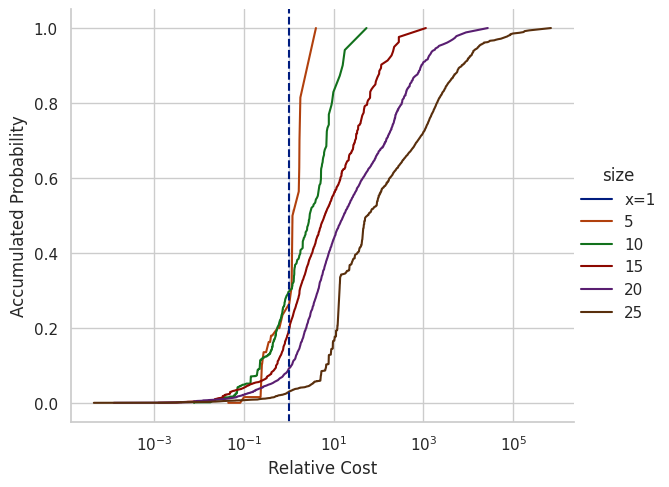

In [8]:
# Graphic (Vertical) that compares BP costs (as the number of visited nodes of the binary tree) when:
#   (a) BP executes a regular DFS to find a solution;
#   (b) BP firstly verify the most frequent root-leaf paths of the BP tree.

def count_visited_nodes_by_dfs(binary):
    """
    # Calculate the number of the BP tree nodes that are explored by the DFS until it finds the solution.
    Parameters:
        binary: Binary string representing the solution: a root-leaf path in the BP tree.
    Returns:
        Integer: The number of visited nodes.
    Note:
        This calculation is done using the following equation:
              DFS_cost(b) = n + sum_{j=1}^{n} < (b_{k})_{k=1}^{n+1-j} , (2^{n-i})_{i=j}^{n} >.
        The symbol < , > represents the dot product of two vectors.
        The element 'n' counts the number of nodes of the solution 'b'.
        The j-th dot product of the sum counts the number of nodes of the BP tree visited by the DFS in the 'n+1-j'-th level.
    """
    n_binary = len(binary)
    binary_int = np.array([int(x) for x in binary])
    exp_base_2 = np.array([2**i for i in range(n_binary-1, -1, -1)])
    
    return np.sum([np.sum(binary_int[0:n_binary-i] * exp_base_2[i:n_binary]) + 1 for i in range(n_binary)])

df_cost = pd.DataFrame(df_count_slices['size'])
df_cost['count'] = df_count_slices['count'].copy()

# calculating the "regular BP" cost to find out the current binary is a valid solution.
df_cost['dfs_cost'] = df_count_slices['b'].apply(lambda x: count_visited_nodes_by_dfs(x))

# indexing the binary subsequences from the most frequent to the less frequent.
indexes_to_plot = []
sizes = df_count_slices['size'].unique()
for size in sizes:
    this_indexes = list(range(len(df_count_slices[df_count_slices['size'] == size])))
    this_indexes = [x+1 for x in range(len(this_indexes))]
    indexes_to_plot = indexes_to_plot + this_indexes
df_cost['index_to_plot'] = indexes_to_plot

# calculating the "preferential BP" cost: the cost to find out if one of the known binary subsequences corresponds to the geometry of the current protein piece.
df_cost['pref_bin_cost'] = (df_cost['index_to_plot'].astype(int)) * df_cost['size'].astype(int)
df_cost = df_cost.drop(['index_to_plot'], axis=1)

# measuring how much more "regular BP" costs than "preferential BP" : dfs_cost / preferable_cost. We call this measurement "speed up".
df_cost['speed_up'] = df_cost.apply(lambda row: row['dfs_cost'].astype(float)/row['pref_bin_cost'].astype(float), axis=1)

# sorting the dataframe from the greatest 'cost speed_up' to the smallest.
df_cost.sort_values(by=['size', 'speed_up'], inplace=True, ascending=True)

# calculate the relative accumulated frequency of the binary subsequences.
acc_freq = []
rel_acc_freq = []
for size in sizes:
    df_size = df_cost[df_cost['size'] == size]
    N_freq = df_size['count'].sum()
    this_acc_freq = df_size['count'].cumsum()
    this_rel_acc_freq = this_acc_freq.copy()
    this_rel_acc_freq = this_rel_acc_freq.apply(lambda x: x/N_freq)

    acc_freq += this_acc_freq.to_list()
    rel_acc_freq += this_rel_acc_freq.to_list()

df_cost['rel_acc_frequency'] = rel_acc_freq

# add horizontal line y=log(1): highlight the cases where 'dfs_cost' and 'pref_bin_cost' have the same cost.
df_cost.loc[len(df_cost.index)] = ['x=1', 1, 1, 1, 1, 0]
df_cost.loc[len(df_cost.index)] = ['x=1', 1, 1, 1, 1, 1]

# constructing the graphic (DFS_cost/FBS_cost) x Accumulated Prob.
my_hue_order = list(df_count_slices['size'].unique())
my_hue_order.insert(0, 'x=1')
g_costs = sns.relplot(df_cost, kind="line", x="speed_up", y="rel_acc_frequency", hue="size", hue_order=my_hue_order, palette=sns.color_palette("dark", n_colors+1), aspect=1.2)
g_costs.set(xscale="log")
g_costs.set_axis_labels(x_var="Relative Cost", y_var="Accumulated Probability")
plt.axvline(1, color=sns.color_palette("dark", 1)[0], linestyle='--')
    

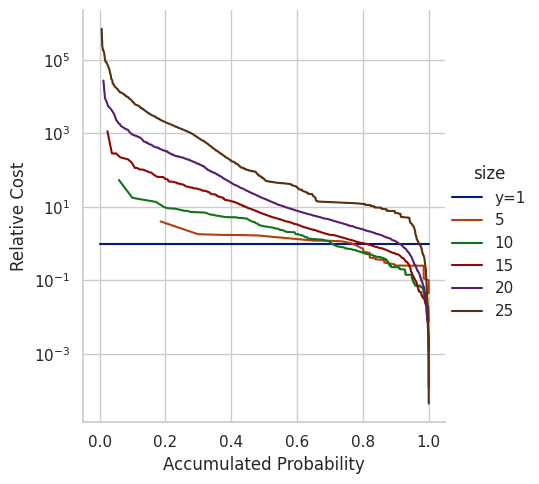

In [5]:
# Graphic (Horizontal) that compares BP costs (as the number of visited nodes of the binary tree) when:
#   (a) BP executes a regular DFS to find a solution;
#   (b) BP firstly verify the most frequent root-leaf paths of the BP tree.

def count_visited_nodes_by_dfs(binary):
    """
    # Calculate the number of the BP tree nodes that are explored by the DFS until it finds the solution.
    Parameters:
        binary: Binary string representing the solution: a root-leaf path in the BP tree.
    Returns:
        Integer: The number of visited nodes.
    Note:
        This calculation is done using the following equation:
              DFS_cost(b) = n + sum_{j=1}^{n} < (b_{k})_{k=1}^{n+1-j} , (2^{n-i})_{i=j}^{n} >.
        The symbol < , > represents the dot product of two vectors.
        The element 'n' counts the number of nodes of the solution 'b'.
        The j-th dot product of the sum counts the number of nodes of the BP tree visited by the DFS in the 'n+1-j'-th level.
    """
    n_binary = len(binary)
    binary_int = np.array([int(x) for x in binary])
    exp_base_2 = np.array([2**i for i in range(n_binary-1, -1, -1)])
    
    return np.sum([np.sum(binary_int[0:n_binary-i] * exp_base_2[i:n_binary]) + 1 for i in range(n_binary)])

df_cost = pd.DataFrame(df_count_slices['size'])
df_cost['count'] = df_count_slices['count'].copy()

# calculating the "regular BP" cost to find out the current binary is a valid solution.
df_cost['dfs_cost'] = df_count_slices['b'].apply(lambda x: count_visited_nodes_by_dfs(x))

# indexing the binary subsequences from the most frequent to the less frequent.
indexes_to_plot = []
sizes = df_count_slices['size'].unique()
for size in sizes:
    this_indexes = list(range(len(df_count_slices[df_count_slices['size'] == size])))
    this_indexes = [x+1 for x in range(len(this_indexes))]
    indexes_to_plot = indexes_to_plot + this_indexes
df_cost['index_to_plot'] = indexes_to_plot

# calculating the "preferential BP" cost: the cost to find out if one of the known binary subsequences corresponds to the geometry of the current protein piece.
df_cost['pref_bin_cost'] = (df_cost['index_to_plot'].astype(int)) * df_cost['size'].astype(int)
df_cost = df_cost.drop(['index_to_plot'], axis=1)

# measuring how much more "regular BP" costs than "preferential BP" : dfs_cost / preferable_cost. We call this measurement "speed up".
df_cost['speed_up'] = df_cost.apply(lambda row: row['dfs_cost'].astype(float)/row['pref_bin_cost'].astype(float), axis=1)

# sorting the dataframe from the greatest 'cost speed_up' to the smallest.
df_cost['size'] = df_cost['size'].apply(lambda x : -x) # keeps the dataframe ordered by size
df_cost.sort_values(by=['size', 'speed_up'], inplace=True, ascending=False) # keeps the dataframe ordered by size
df_cost['size'] = df_cost['size'].apply(lambda x : -x) # keeps the dataframe ordered by size

# calculate the relative accumulated frequency of the binary subsequences.
acc_freq = []
rel_acc_freq = []
for size in sizes:
    df_size = df_cost[df_cost['size'] == size]
    N_freq = df_size['count'].sum()
    this_acc_freq = df_size['count'].cumsum()
    this_rel_acc_freq = this_acc_freq.copy()
    this_rel_acc_freq = this_rel_acc_freq.apply(lambda x: x/N_freq)

    acc_freq += this_acc_freq.to_list()
    rel_acc_freq += this_rel_acc_freq.to_list()

df_cost['rel_acc_frequency'] = rel_acc_freq

# add horizontal line y=log(1): highlight the cases where 'dfs_cost' and 'pref_bin_cost' have the same cost.
df_cost.loc[len(df_cost.index)] = ['y=1', 1, 1, 1, 1, 0]
df_cost.loc[len(df_cost.index)] = ['y=1', 1, 1, 1, 1, 1]

# constructing the graphic Accumulated Prob x (DFS_cost/FBS_cost).
my_hue_order = list(df_count_slices['size'].unique())
my_hue_order.insert(0, 'y=1')
g_costs = sns.relplot(df_cost, kind="line", x="rel_acc_frequency", y="speed_up", hue="size", hue_order=my_hue_order, palette=sns.color_palette("dark", n_colors+1))
g_costs.set(yscale="log")
g_costs.set_axis_labels(x_var="Accumulated Probability", y_var="Relative Cost")

Text(0, 0.5, 'RF(1st_biggest) / RF(2nd_biggest)')

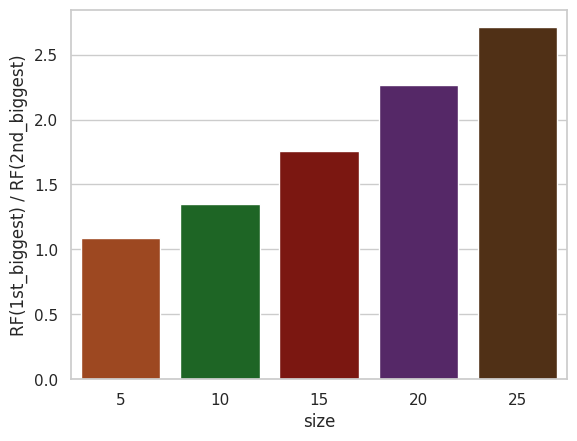

In [8]:
# Create a graphic that shows the ratio of the most frequent binary subsequence and the second most frequent.

df_2most_freq = df_count_slices.groupby(['size']).agg({'count': 'max'}).reset_index()
df_2most_freq = df_2most_freq.rename(columns={'count': 'big_1st'})

most_freq_indices = [np.flatnonzero((df_count_slices['size'] == row.loc['size']) & (df_count_slices['count'] == row.loc['big_1st']))[0].astype(int) for _, row in df_2most_freq.iterrows()]
df_2most_freq['big_2nd'] = [df_count_slices.iloc[i+1].loc['count'] for i in most_freq_indices]

df_2most_freq['N_freq'] = df_count_slices.groupby(['size'])['count'].sum().reset_index()['count']

df_2most_freq['rel_big_1st'] = df_2most_freq.apply(lambda row: row.loc['big_1st']/row.loc['N_freq'], axis=1)
df_2most_freq['rel_big_2nd'] = df_2most_freq.apply(lambda row: row.loc['big_2nd']/row.loc['N_freq'], axis=1)

df_2most_freq['ratio_1st_to_2nd'] = df_2most_freq.apply(lambda row: row.loc['rel_big_1st']/row.loc['rel_big_2nd'], axis=1)

g_2most_freq = sns.barplot(df_2most_freq, x="size", y="ratio_1st_to_2nd", hue='size', palette=sns.color_palette("dark",)[1:6], legend=False)
g_2most_freq.set_ylabel("RF(1st_biggest) / RF(2nd_biggest)")